In [1]:
import torch
import torch.nn as nn
import pandas as pd
from skimage import io
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.optim as optim
import timm
import os
import torchvision.models as models

import pathlib
from torchvision.datasets import ImageFolder

import time
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')

In [3]:
torch.cuda.empty_cache()

In [4]:
SEED = set_seed(seed=40, seed_torch=True)

Random seed 40 has been set.


In [5]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [6]:
set_device()

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu


'cuda'

In [7]:
print(torch.cuda.is_available())

True


In [8]:
## path dataset

path = '/home/alex/datasets/histopathologic_cancer_detection_kaggle/histopathologic-cancer-detection/'

In [9]:
df_breast_cancer = pd.read_excel('/home/alex/datasets/histopathologic_cancer_detection_kaggle/histopathologic-cancer-detection/labels_train_tif.xlsx')
df_breast_cancer

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576.tif,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75.tif,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2.tif,0


In [10]:
print(f'{len(os.listdir(f"{path}/train"))} pictures in training set.')
print(f'{len(os.listdir(f"{path}/test"))} pictures in test set.')

220025 pictures in training set.
57458 pictures in test set.


In [11]:
Counter(df_breast_cancer['label'])

Counter({0: 130908, 1: 89117})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f02ede97d90>]],
      dtype=object)

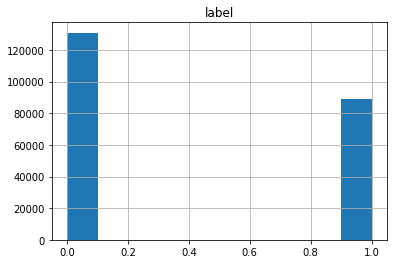

In [12]:
df_breast_cancer.hist(column='label')

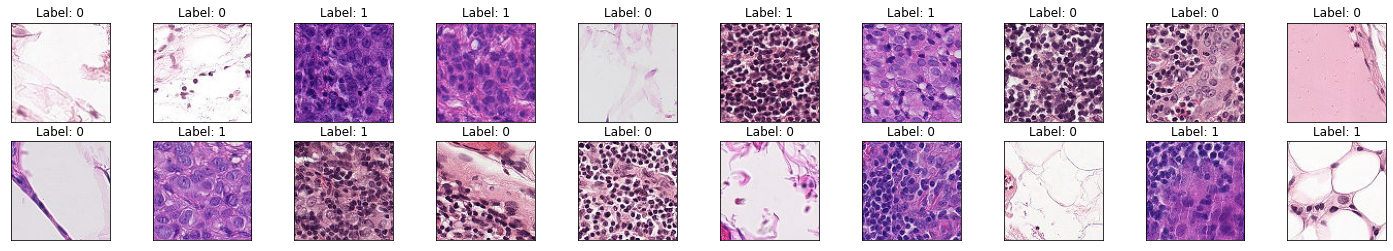

In [13]:
fig = plt.figure(figsize=(25, 4))
# display 20 images
train_imgs = os.listdir(f"{path}/train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(f"{path}/train/" + img)
    plt.imshow(im)
    lab = df_breast_cancer.loc[df_breast_cancer['id'] == img, 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [77]:
data_transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
data_transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [78]:
data_transforms_train

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [86]:
## split data into train and validation set
train_set, val_set = train_test_split(df_breast_cancer.label, stratify=df_breast_cancer.label, train_size=0.8)

In [93]:
train_set.dtype

dtype('int64')

In [101]:
df_train

,id,label
0,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
1,755db6279dae599ebb4d39a9123cce439965282d.tif,0
2,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
3,068aba587a4950175d04c680d38943fd488d6a9d.tif,0
4,acfe80838488fae3c89bd21ade75be5c34e66be7.tif,0
...,...,...
176015,cdf7171a796090072ce521012497c78c9a56cad3.tif,0
176016,1fdacc29221a64e39d5d294d114c9e29da8705ae.tif,0
176017,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif,0
176018,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75.tif,0


In [100]:
df_breast_cancer.loc[train_set] ^ 

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
...,...,...
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0


In [97]:
df_breast_cancer

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576.tif,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75.tif,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2.tif,0


In [96]:
df_breast_cancer.loc[train_set[:,0]]

ValueError: Can only tuple-index with a MultiIndex

In [44]:
df_train = df_breast_cancer
df_valid = df_breast_cancer

for index, row in df_breast_cancer.iterrows():
    if index not in train_set:
        df_train = df_train.drop(index)
    elif index in train_set:
        df_valid = df_valid.drop(index)
        
        

In [48]:
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

In [ ]:
df_train

In [45]:
len(df_train), len(df_valid)

(176020, 44005)

In [53]:
df_train

,id,label
0,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
1,755db6279dae599ebb4d39a9123cce439965282d.tif,0
2,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
3,068aba587a4950175d04c680d38943fd488d6a9d.tif,0
4,acfe80838488fae3c89bd21ade75be5c34e66be7.tif,0
...,...,...
176015,cdf7171a796090072ce521012497c78c9a56cad3.tif,0
176016,1fdacc29221a64e39d5d294d114c9e29da8705ae.tif,0
176017,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif,0
176018,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75.tif,0


In [70]:
df_train.to_excel('/home/alex/Downloads/dfs convnet/df_train.xlsx', index=False)

In [71]:
df_valid.to_excel('/home/alex/Downloads/dfs convnet/df_valid.xlsx', index=False)

In [74]:
## load data
dataset_train = PathologyDataset(excel_file = '/home/alex/Downloads/dfs convnet/df_train.xlsx', root_dir = '/home/alex/datasets/histopathologic_cancer_detection_kaggle/histopathologic-cancer-detection/train', transform = data_transforms_train)
dataset_val = PathologyDataset(excel_file = '/home/alex/Downloads/dfs convnet/df_valid.xlsx', root_dir = '/home/alex/datasets/histopathologic_cancer_detection_kaggle/histopathologic-cancer-detection/train', transform = data_transforms_test)

In [75]:
batch_size = 256

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)

In [29]:
# # dictionary with labels and ids of train data
# img_class_dict = {k:v for k, v in zip(df_breast_cancer.id, df_breast_cancer.label)}

# img_class_dict

In [72]:
class PathologyDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.annotations = dataframe
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations) 
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
            
        return(image, y_label)

In [73]:
class PathologyDataset(Dataset):
    def __init__(self, excel_file, root_dir, transform=transforms.ToTensor()):
        self.annotations = pd.read_excel(excel_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations) 
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
            
        return(image, y_label)

In [60]:
# Make a CNN & train it to predict genres.

class conv_net(nn.Module):
    def __init__(self):
        """Intitalize neural net layers"""
        super(conv_net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=3200, out_features=2)

        self.batchnorm1 = nn.BatchNorm2d(num_features=8)
        self.batchnorm2 = nn.BatchNorm2d(num_features=16)
        self.batchnorm3 = nn.BatchNorm2d(num_features=32)

        self.dropout = nn.Dropout(p=0.3, inplace=False)


    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 2.
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 3.
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        #print(x.shape)
        # Fully connected layer 1.
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.softmax(x)

        return x


def train(model, device, train_loader, validation_loader, epochs):
    criterion =  nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            model.train()
            # keep track of the running loss
            running_loss = 0.
            correct, total = 0, 0

            for data, target in train_loader:
                # getting the training set
                data = data.permute(0,3,1,2).float()
                data, target = data.to(device), target.to(device)
                #print(data.shape, target.shape)
                # Get the model output (call the model with the data from this batch)
                output = model(data)
                # Zero the gradients out)
                optimizer.zero_grad()
                # Get the Loss
                loss  = criterion(output, target)
                # Calculate the gradients
                loss.backward()
                # Update the weights (using the training step of the optimizer)
                optimizer.step()

                tepochs.set_postfix(loss=loss.item())
                running_loss += loss  # add the loss for this batch

                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            # append the loss for this epoch
            train_loss.append(running_loss/len(train_loader))
            train_acc.append(correct/total)

            # evaluate on validation data
            model.eval()
            running_loss = 0.
            correct, total = 0, 0

            for data, target in validation_loader:
                # getting the validation set
                data = data.permute(0,3,1,2).float()
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()
                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            validation_loss.append(running_loss/len(validation_loader))
            validation_acc.append(correct/total)

    return train_loss, train_acc, validation_loss, validation_acc

In [33]:
## load data
dataset_train = PathologyDataset(excel_file = '/home/alex/datasets/histopathologic_cancer_detection_kaggle/histopathologic-cancer-detection/labels_train_tif.xlsx', root_dir = '/home/alex/datasets/histopathologic_cancer_detection_kaggle/histopathologic-cancer-detection/train', transform = data_transforms_train)

In [34]:
dataset_val = PathologyDataset(excel_file = '/home/alex/datasets/histopathologic_cancer_detection_kaggle/histopathologic-cancer-detection/labels_train_tif.xlsx', root_dir = '/home/alex/datasets/histopathologic_cancer_detection_kaggle/histopathologic-cancer-detection/train', transform = data_transforms_test)

In [25]:
len(train_set)

176020

In [63]:
batch_size = 256

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
# Make a CNN & train it to predict genres.

class conv_net(nn.Module):
    def __init__(self):
        """Intitalize neural net layers"""
        super(conv_net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=3200, out_features=2)

        self.batchnorm1 = nn.BatchNorm2d(num_features=8)
        self.batchnorm2 = nn.BatchNorm2d(num_features=16)
        self.batchnorm3 = nn.BatchNorm2d(num_features=32)

        self.dropout = nn.Dropout(p=0.3, inplace=False)


    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 2.
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 3.
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        #print(x.shape)
        # Fully connected layer 1.
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.softmax(x)

        return x


def train(model, device, train_loader, validation_loader, epochs):
    criterion =  nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            model.train()
            # keep track of the running loss
            running_loss = 0.
            correct, total = 0, 0

            for data, target in train_loader:
                # getting the training set
                data = data.permute(0,3,1,2).float()
                data, target = data.to(device), target.to(device)
                #print(data.shape, target.shape)
                # Get the model output (call the model with the data from this batch)
                output = model(data)
                # Zero the gradients out)
                optimizer.zero_grad()
                # Get the Loss
                loss  = criterion(output, target)
                # Calculate the gradients
                loss.backward()
                # Update the weights (using the training step of the optimizer)
                optimizer.step()

                tepochs.set_postfix(loss=loss.item())
                running_loss += loss  # add the loss for this batch

                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            # append the loss for this epoch
            train_loss.append(running_loss/len(train_loader))
            train_acc.append(correct/total)

            # evaluate on validation data
            model.eval()
            running_loss = 0.
            correct, total = 0, 0

            for data, target in validation_loader:
                # getting the validation set
                data = data.permute(0,3,1,2).float()
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()
                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            validation_loss.append(running_loss/len(validation_loader))
            validation_acc.append(correct/total)

    return train_loss, train_acc, validation_loss, validation_acc

In [61]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

In [76]:
# Run training.

net = conv_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, valid_loader, 10)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)

KeyError: 38730

<ipython-input-65-6cb70f63350e>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


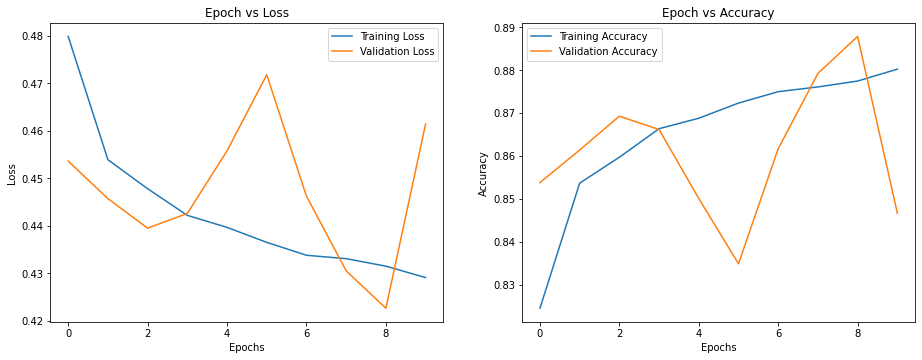

In [67]:
# Run training.

net = conv_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, valid_loader, 10)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)

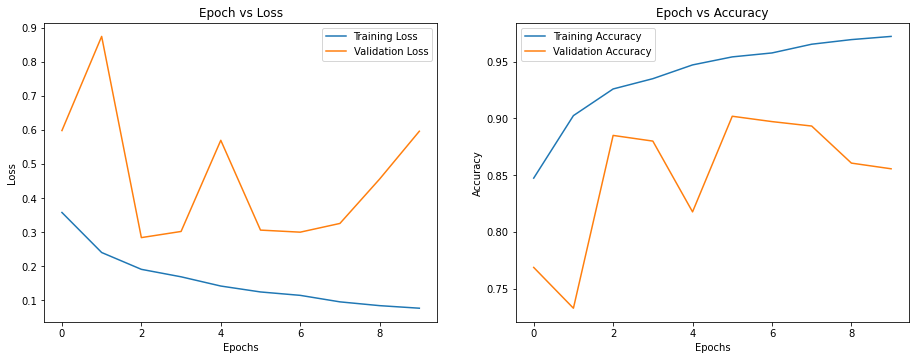

In [21]:
net = ResNet50(img_channel=3, num_classes=2).to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, valid_loader, 10)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)

In [ ]:
net = ResNet50(img_channel=3, num_classes=2).to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, valid_loader, 10)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)

In [22]:
torch.cuda.empty_cache()

In [ ]:
# Run training.

net = conv_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, valid_loader, 10)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)

In [32]:
# Run training.

net = conv_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, valid_loader, 10)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)

<ipython-input-31-6cb70f63350e>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


NameError: name 'plot_loss_accuracy' is not defined

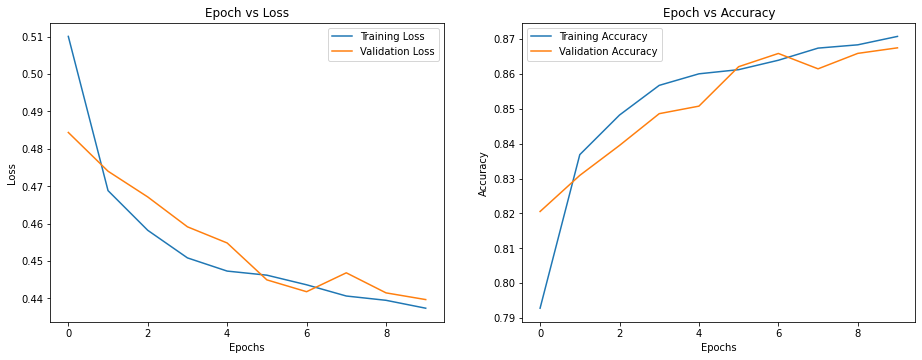

In [34]:
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)

In [62]:
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False, device='cpu'):

    net.train()
    training_losses = []
    for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            if verbose:
                training_losses += [loss.item()]

    net.eval()
    def test(data_loader):
        correct = 0
        total = 0
        for data in data_loader:
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        return total, acc

    train_total, train_acc = test(train_loader)
    test_total, test_acc = test(test_loader)

    if verbose:
        print(f"Accuracy on the {train_total} training samples: {train_acc:0.2f}")
        print(f"Accuracy on the {test_total} testing samples: {test_acc:0.2f}")

    if training_plot:
        plt.plot(training_losses)
        plt.xlabel('Batch')
        plt.ylabel('Training loss')
        plt.show()

    return train_acc, test_acc

In [64]:
set_seed(SEED)
net = model.to(device)#, X_train.shape[1], [128], K).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 5

_, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=device)

Random seed 4170016563 has been set.


TypeError: 'list' object is not callable

In [ ]:
# -*- coding: utf-8 -*-
"""
From scratch implementation of the famous ResNet models.
The intuition for ResNet is simple and clear, but to code
it didn't feel super clear at first, even when reading Pytorch own
implementation. 
Video explanation: 
Got any questions leave a comment on youtube :)
Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
*    2020-04-12 Initial coding
"""

import torch
import torch.nn as nn


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


def test():
    net = ResNet101(img_channel=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(y.size())


test()

Random seed 1751002438 has been set.



Accuracy on the 176020 training samples: 98.20
Accuracy on the 44005 testing samples: 96.78


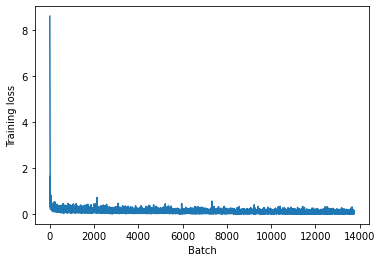

In [38]:
set_seed(SEED)
net = model.to(device)#, X_train.shape[1], [128], K).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 5

_, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=device)